In [1]:
import pandas as pd
import numpy as np

# 1035, 258
train = pd.read_csv('/Users/bdlab/Desktop/sparse-matrix-multiplication/scenario-extraction/d-optimal/spmm-latency-traintest/train-test-csv/nonsquare-train-1035-from-spmm-contain-todense-over-3s-1293.csv')
test = pd.read_csv('/Users/bdlab/Desktop/sparse-matrix-multiplication/scenario-extraction/d-optimal/spmm-latency-traintest/train-test-csv/nonsquare-test-258-from-spmm-contain-todense-over-3s-1293.csv')

In [2]:
# # feature 1개 추가 -> MAPE 9

# # Train + Valid
# X_train = train[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','lr*lc*rc','ld*rd','lr*rc*ld*rd','lr*lc*rc*ld*rd','lnnz*rnnz']] 
# y_train = train['bz_smsm']

# # Test
# X_test = test[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','lr*lc*rc','ld*rd','lr*rc*ld*rd','lr*lc*rc*ld*rd','lnnz*rnnz']] 
# y_test = test['bz_smsm']

In [3]:
# Train + Valid
X_train = train[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','lr*lc*rc','ld*rd' ]] 
y_train = train['bz_smsm']

# Test
X_test = test[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','lr*lc*rc','ld*rd']] 
y_test = test['bz_smsm']

In [4]:
# # Train + Valid
# X_train = train[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','ld*rd' ]] 
# y_train = train['bz_smsm']

# # Test
# X_test = test[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','ld*rd']] 
# y_test = test['bz_smsm']

In [5]:
from sklearn.metrics import r2_score, mean_squared_error

# Metric
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

def custom_scoring(real, pred):
    rmse = np.sqrt(mean_squared_error(real, pred))
    r2 = r2_score(real, pred)
    mape = mean_absolute_percentage_error(real, pred)
    return mape

In [6]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

# 탐색 대상 함수 (XGBRegressor)
def XGB(
max_depth,
learning_rate, 
n_estimators, 
#min_child_weight, 
subsample,
_lambda,
#gamma ,
colsample_bytree, 
#_alpha,
silent=True, 
n_jobs=-1):
    
    # 모델 정의
    model = xgb.XGBRegressor( 
objective = 'reg:squarederror',
max_depth=int(max_depth),
learning_rate=learning_rate,
n_estimators=int(n_estimators),
#min_child_weight=min_child_weight,
subsample=subsample,
reg_lambda=_lambda,        
#gamma=gamma,
colsample_bytree=colsample_bytree, 
#reg_alpha=_alpha
n_jobs=n_jobs        
                              )
    
    # bayesian optimization을 통해 파라미터를 받아
    # Train을 Train + Validation으로 나눠 cross-validation 성능 확인
    kfold = KFold(n_splits=9, shuffle = True, random_state=0)

    # cross-validation 평균 성능 성능 확인
    score = cross_val_score(model,
                            X_train, 
                            y_train, 
                            cv=kfold,
                            scoring=make_scorer(custom_scoring,greater_is_better=False),
                            n_jobs=-1
                           ).mean()
    
    return score

In [7]:
from bayes_opt import BayesianOptimization

# 하이퍼파라미터 정의
pbounds = {
'max_depth': (15, 23), 
'learning_rate': (0.01, 0.3),
'n_estimators': (50, 150),
#'min_child_weight': (0.1, 1),
'subsample': (0.5, 1), 
'_lambda' : (0.1,1),    
#'gamma': (0, 0.3),     
'colsample_bytree' :(0.5, 1)
#'_alpha' : (0,1)           
                      }

# Bayesian optimization 객체 생성
bo=BayesianOptimization(f=XGB, pbounds=pbounds, verbose=2, random_state=1 )    

# 메소드를 이용해 최대화 과정 수행 (파라미터 넣고 목적함수 값 출력하고)
bo.maximize(init_points=2, n_iter=50, acq='ei', xi=0.01)

# 뽑힌 최적의 하이퍼파라미터 값 확인
print("{}\n".format(bo.max))

|   iter    |  target   |  _lambda  | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -48.45    |  0.4753   |  0.8602   |  0.01003  |  17.42    |  64.68    |  0.5462   |
|  2        | -30.29    |  0.2676   |  0.6728   |  0.1251   |  19.31    |  91.92    |  0.8426   |
|  3        | -29.27    |  0.4741   |  0.7286   |  0.07077  |  19.09    |  92.1     |  0.7691   |
|  4        | -25.63    |  0.2907   |  0.6707   |  0.274    |  19.05    |  92.48    |  0.7218   |
|  5        | -33.18    |  0.107    |  0.6692   |  0.08626  |  19.29    |  92.55    |  0.9315   |
|  6        | -39.41    |  0.4686   |  0.5611   |  0.2217   |  21.94    |  116.3    |  0.6975   |
|  7        | -35.53    |  0.3866   |  0.743    |  0.2997   |  18.96    |  92.51    |  0.5045   |
|  8        | -25.78    |  0.7246   |  0.7868   |  0.1054   |  20.68    |  129.7    |  0.5152   |
|  9        | -39.61

|  51       | -28.72    |  0.1991   |  0.6673   |  0.2264   |  22.55    |  141.3    |  0.8711   |
|  52       | -35.65    |  0.1305   |  0.6525   |  0.0258   |  19.78    |  128.4    |  0.633    |
{'target': -21.346035458131926, 'params': {'_lambda': 0.9671716237976958, 'colsample_bytree': 0.9784517810866844, 'learning_rate': 0.04507011754186229, 'max_depth': 16.992869637868704, 'n_estimators': 62.21252826172613, 'subsample': 0.8545270296912297}}



In [8]:
import xgboost as xgb

# Train + Valid cross-validation을 거친, 최적의 하이퍼파라미터를 사용
best_model = xgb.XGBRegressor(
objective = 'reg:squarederror',
max_depth=int(bo.max['params']['max_depth']),
learning_rate=bo.max['params']['learning_rate'],
n_estimators=int(bo.max['params']['n_estimators']),
#min_child_weight=bo.max['params']['min_child_weight'],
subsample=bo.max['params']['subsample'],
reg_lambda = bo.max['params']['_lambda'],    
#gamma=bo.max['params']['gamma'],
colsample_bytree=bo.max['params']['colsample_bytree'],
#reg_alpha = bo.max['params']['_alpha'],
n_jobs=-1
                             )
# 모델 훈련
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9784517810866844, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.04507011754186229, max_delta_step=0, max_depth=16,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=62, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=0.9671716237976958, scale_pos_weight=1,
             subsample=0.8545270296912297, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [9]:
# 최적의 하이퍼파라미터 값 확인
print("{}\n".format(bo.max))

# 훈련데이터 예측
y_train_pred = best_model.predict(X_train)
print("-------- 훈련데이터 예측 --------------------------")
print("rmse : {}".format(np.sqrt(mean_squared_error(y_train, y_train_pred))))
print("mape : {}%".format(mean_absolute_percentage_error(y_train, y_train_pred)))
print("\n")

# 검증데이터 예측
print("-------- 검증데이터 예측 --------------------------")
print("mape : {}%".format(-bo.max['target']))
print("\n")

# 테스트데이터 예측
y_pred = best_model.predict(X_test)
print("-------- 테스트데이터 예측 -------------------------")
print("rmse : {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("mape : {}%".format(mean_absolute_percentage_error(y_test, y_pred)))
print("\n")

{'target': -21.346035458131926, 'params': {'_lambda': 0.9671716237976958, 'colsample_bytree': 0.9784517810866844, 'learning_rate': 0.04507011754186229, 'max_depth': 16.992869637868704, 'n_estimators': 62.21252826172613, 'subsample': 0.8545270296912297}}

-------- 훈련데이터 예측 --------------------------
rmse : 15537.430092693421
mape : 6.782524206258678%


-------- 검증데이터 예측 --------------------------
mape : 21.346035458131926%


-------- 테스트데이터 예측 -------------------------
rmse : 26593.507281011956
mape : 17.114776046054253%




In [10]:
# mape_list = {}
# # 예측값, 실제값을 확인하며 mape 계산 후 mape_list에 삽입 
# for idx,value in enumerate(y_test):
#     mape_temp = {}
#     predicate = int(y_pred[idx])
#     mape = abs((value - predicate) / value) * 100
#     mape_temp['pred'] = predicate
#     mape_temp['real'] = value
#     mape_temp['mape'] = mape
#     mape_list[idx] = mape_temp
# mape_list_sort = sorted(mape_list.values(), key=lambda x:(x['mape']), reverse=True)
# mape_list_sort  

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

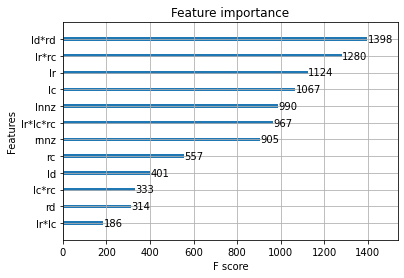

In [11]:
xgb.plot_importance(best_model)